In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 38.0 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import re
import glob
import numpy as np
import pandas as pd
from pandas import Series
from pandas import Series, DataFrame
import math
from datetime import datetime
import os
import zipfile
import shutil
import ast
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import statistics
from sklearn.svm import SVC
from sklearn.model_selection import (train_test_split, GridSearchCV, RepeatedStratifiedKFold)
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,auc, roc_curve, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import (LabelEncoder,OneHotEncoder, StandardScaler)  
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import datasets
from sklearn import metrics
import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, LSTM, Bidirectional, Dropout, MaxPooling2D, BatchNormalization, Activation, Embedding, Input
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.optimizers as optimizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

# Descargando la base de datos de Comentarios

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alonsopuente","key":"a2490af4bf49c88fb2df45cdbad9784f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Cambiamos los permisos
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alonsopuente/kickstarter-projects-metadata
!kaggle datasets download -d alonsopuente/kickstarter-projects-comments
!ls

 69% 4.00M/5.78M [00:00<00:00, 40.7MB/s]
100% 5.78M/5.78M [00:00<00:00, 53.5MB/s]
 90% 57.0M/63.3M [00:01<00:00, 55.5MB/s]
100% 63.3M/63.3M [00:01<00:00, 62.2MB/s]
kaggle.json			   kickstarter-projects-metadata.zip
kickstarter-projects-comments.zip  sample_data


In [ ]:
!kaggle datasets download -d srbhshinde/gloveicg

 99% 1.63G/1.65G [00:16<00:00, 172MB/s]
100% 1.65G/1.65G [00:16<00:00, 110MB/s]


In [ ]:
!unzip -qq gloveicg.zip

In [ ]:
os.mkdir('folder')
zip_train_test_md = zipfile.ZipFile('kickstarter-projects-metadata.zip','r')
zip_train_test_md.extractall()
zip_train_test_md.close()
zip_train_test_md = zipfile.ZipFile('kickstarter-projects-comments.zip','r')
zip_train_test_md.extractall()
zip_train_test_md.close()
os.rename('kickstarter-projects-metadata.zip','folder/kickstarter-projects-metadata.zip')
os.rename('kickstarter-projects-comments.zip','folder/kickstarter-projects-comments.zip')
shutil.rmtree('folder')

# Cargando la BD

In [ ]:
## configurar el ancho de la columna
pd.options.display.max_colwidth = 100
pd.options.display.max_colwidth

100

In [ ]:
metadata = pd.read_csv("Metadata.csv",sep = ',')
metadata.head()

,id,backers_count,name,blurb,category,photo,urls,city,country,goal,pledge_amounts,pledged,currency,usd_pledged,created_at,launched_at,deadline,duration,state
0,1000245024,0,Safer Home,"Placing furniture against traditional plugs is problematic and hazardous, my goal is to eliminat...",Hardware,https://ksr-ugc.imgix.net/assets/011/663/874/0d51c93f003e10b7fa539040ad0d7a21_original.gif?crop=...,https://www.kickstarter.com/projects/homesafety/safer-home?ref=category_newest,Kamloops,CA,50000.0,[10],0.0,CAD,0.000000,"March 09, 2014","June 03, 2015","July 03, 2015",30,failed
1,1000256230,0,Shreddit - Privacy on Reddit,"Shreddit, a Reddit privacy tool I created and have maintained for 4 years needs to become user f...",Software,https://ksr-ugc.imgix.net/assets/013/466/903/048a5685f8b72627381bcd365d08a162_original.png?ixlib...,https://www.kickstarter.com/projects/466914929/shreddit-privacy-on-reddit?ref=discovery_category...,Edinburgh,GB,2000.0,"[10, 25, 35, 50]",0.0,GBP,0.000000,"August 23, 2016","June 02, 2017","July 02, 2017",30,failed
2,1000261018,3,Diposta - liberating people from their postal mailbox.,"The problem of mail: it is physical! Diposta collects, digitizes, and provides daily postal mail...",Web,https://ksr-ugc.imgix.net/assets/012/071/808/109c2837de24229820849e9336054aba_original.jpg?ixlib...,https://www.kickstarter.com/projects/105350477/diposta-liberating-people-from-their-postal-mailb...,Raleigh,US,100000.0,"[40, 99, 199]",141.0,USD,141.000000,"March 17, 2015","July 24, 2016","August 23, 2016",30,failed
3,100039820,3,Best Spray Bottle Ever - SureShot,Ever had a spray bottle that has a little bit of fluid left in it and the siphon hose just won't...,Gadgets,https://ksr-ugc.imgix.net/assets/012/009/461/3859875d5cc367076b66279f444eeac9_original.jpg?ixlib...,https://www.kickstarter.com/projects/1101368489/best-spray-bottle-ever-sureshot?ref=category_newest,Edmonton,CA,25000.0,[10],3.0,CAD,2.411101,"January 22, 2015","February 05, 2015","March 07, 2015",30,failed
4,1000468345,6,The iRNinja - Simplify your TV with a wireless wall switch,Control your TV & Audio/Video components by pressing a button on the wall!!,Gadgets,https://ksr-ugc.imgix.net/assets/016/561/251/177076c636626b0502560747ae0830e0_original.jpg?ixlib...,https://www.kickstarter.com/projects/5877985/irninja-control-your-tv-with-a-simple-press-of-a-b?...,Jupiter,US,500.0,"[1, 10, 249, 300, 375, 425]",74.0,USD,74.000000,"April 27, 2017","May 10, 2017","June 14, 2017",35,failed


In [ ]:
comentarios = pd.read_csv("comments_clean.csv",sep = ',')
comentarios = metadata.merge(comentarios, on='id', how='left', indicator=True)
comentarios = comentarios.reindex(columns=['id','comments','state'])
comentarios.iloc[:, 1] = comentarios.iloc[:, 1].apply(lambda s: list(ast.literal_eval(s)))
comentarios.head(10)

,id,comments,state
0,1000245024,[],failed
1,1000256230,[],failed
2,1000261018,[],failed
3,100039820,[],failed
4,1000468345,[Electrical Solutions Group installed the iRNinja at my parents house and they love it They use ...,failed
5,1000551777,[],failed
6,1000558429,[],failed
7,1000590709,[],failed
8,1000624031,[],failed
9,1000629643,[ Alex In my country taxes and fees are really high when you send the ODIN if you declare the OD...,successful


In [ ]:
project_comments = []
for word in comentarios['comments']:
  if (len(word) == 0):
    comments = 'kuwagatabaizan'
    #comments = ''
    #comments = np.nan
    project_comments.append(comments)
  else:
    comments = ' '.join(word)
    project_comments.append(comments)

column_names = ["id", "comments", "state"]
df1 = pd.DataFrame(columns = column_names, data = zip(list(comentarios['id']),project_comments,list(comentarios['state'])))

In [ ]:
df1.head(n=20)

,id,comments,state
0,1000245024,kuwagatabaizan,failed
1,1000256230,kuwagatabaizan,failed
2,1000261018,kuwagatabaizan,failed
3,100039820,kuwagatabaizan,failed
4,1000468345,Electrical Solutions Group installed the iRNinja at my parents house and they love it They use t...,failed
5,1000551777,kuwagatabaizan,failed
6,1000558429,kuwagatabaizan,failed
7,1000590709,kuwagatabaizan,failed
8,1000624031,kuwagatabaizan,failed
9,1000629643,Alex In my country taxes and fees are really high when you send the ODIN if you declare the ODI...,successful


In [ ]:
"""
column_names = ["id", "comments", "state"]

cont = 0
lista = []

for i in comentarios.itertuples():

  if (len(i.comments) == 0):    
    ll = [i.id, ["kuwagatabaizan"], i.state]
    lista.append(ll)
    #df1.append(df, ignore_index=True)
    #cont = cont + 1
  else:
    for j in i.comments:
      ll = [i.id, [j], i.state]
      lista.append(ll)
    
  cont += 1

df1 = pd.DataFrame(columns = column_names, data = lista)
#"""

In [ ]:
"""
column_names = ["id", "comments", "state"]

cont = 0
lista = []

for i in comentarios.itertuples():
  for j in i.comments:
    ll = [i.id, [j], i.state]
    lista.append(ll)
    
  cont += 1

df1 = pd.DataFrame(columns = column_names, data = lista)
"""

# Pre-procesamiento de la data

Fuente: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

In [ ]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
X = []
sentences = list(df1['comments'])
"""
for sen in sentences:
  X.append(preprocess_text(sen))

tokenizer = RegexpTokenizer(r'\w+')
"""
X = []
sentences = list(df1['comments'])
for index in sentences:
    #re_special_chars = []
    
    #for text in index:
      #raw = text.lower()
      #fin = preprocess_text(text)
      #fin = text

    X.append(index)

In [ ]:
X[:10]

['kuwagatabaizan',
 'kuwagatabaizan',
 'kuwagatabaizan',
 'kuwagatabaizan',
 'Electrical Solutions Group installed the iRNinja at my parents house and they love it They use to call me every night so that they could watch Netflix would have to walk them through changing the TV source to their Roku turning on their audio receiver and starting Netflix Not anymore now they just press one button  Awesome product would like to get one asap Wish you best of luck ',
 'kuwagatabaizan',
 'kuwagatabaizan',
 'kuwagatabaizan',
 'kuwagatabaizan',
 ' Alex In my country taxes and fees are really high when you send the ODIN if you declare the ODIN having low value like chinese websites it would be very helpfull for me and maybe for more people   Watching was thinking about your proposition and think it not really honest In my mind it impossible doing that but thank you for your help Daniel called this morning to rent projector and can take it tomorrow Thank you for your help didn know it was possible t

In [ ]:
df1.groupby('state').count()

,id,comments
state,,
failed,19501,3111
successful,7750,4574


In [ ]:
print(round((df1.groupby('state').count()['comments']/df1.count()['comments'])*100,0))
print(df1.groupby('state').count()['comments'])

state
failed        40.0
successful    60.0
Name: comments, dtype: float64
state
failed        3111
successful    4574
Name: comments, dtype: int64


In [ ]:
lower_case = []
for tex in X:
    new_text = tex.lower()
    lower_case.append(new_text)

tokens = []
for text in lower_case:
    new_text = word_tokenize(text)
    tokens.append(new_text)
stop_words = set(stopwords.words('english'))

re_stopwords = []
for lista in tokens:
    not_stopwords = []
    for w in lista:
        if w not in stop_words:
            not_stopwords.append(w)
    re_stopwords.append(not_stopwords)

lemmatizer = WordNetLemmatizer()
lemmatization = []

for lista in re_stopwords:
    lemmas = []
  
    for w in lista:  
        word1 = lemmatizer.lemmatize(w, pos = "n")      #Lematizando con NLTK
        word2 = lemmatizer.lemmatize(word1, pos = "v")
        word3 = lemmatizer.lemmatize(word2, pos = ("a"))
        lemmas.append(word3)
        #new_text = lemmatize_with_postag(w)  #Lematizando con TextBlob
    
    lemmatization.append(lemmas)

text_clean = []
for lista in lemmatization:
    text = " ".join(lista).strip()
    text_clean.append(text)

X = text_clean
del lower_case
del tokens
del re_stopwords
del lemmatization
del text_clean

In [ ]:
X[:15]

['kuwagatabaizan',
 'kuwagatabaizan',
 'kuwagatabaizan',
 'kuwagatabaizan',
 'electrical solution group instal irninja parent house love use call every night could watch netflix would walk change tv source roku turn audio receiver start netflix anymore press one button awesome product would like get one asap wish best luck',
 'kuwagatabaizan',
 'kuwagatabaizan',
 'kuwagatabaizan',
 'kuwagatabaizan',
 'alex country tax fee really high send odin declare odin low value like chinese website would helpfull maybe people watch think proposition think really honest mind impossible thank help daniel call morning rent projector take tomorrow thank help know possible rent projector quite expensive month rent pay new projector say msrp odin understand mean back project pay lot tax receive think spend le money msrp think spend money sure understand monthieu laurent choice personal computer projector many problem company hardware without choice back project need portative projector stay home underst

In [ ]:
Y = df1['state']
Y = np.array(list(map(lambda x: 1 if x=="successful" else 0, Y)))

In [ ]:
Y[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1])

In [ ]:
Y.shape

(27251,)

# Análisis exploratorio

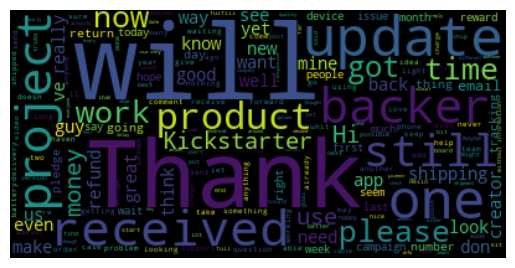

In [ ]:
# Solo para obtener la nube de palabras de la data original
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
all_comments = []
for text in list(comentarios['comments']):
  text = " ".join(text).strip()
  all_comments.append(text)
long_string = ','.join(all_comments)
# Create a WordCloud object
#wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud = WordCloud(collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
#wordcloud.to_image()
plt.rcdefaults()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

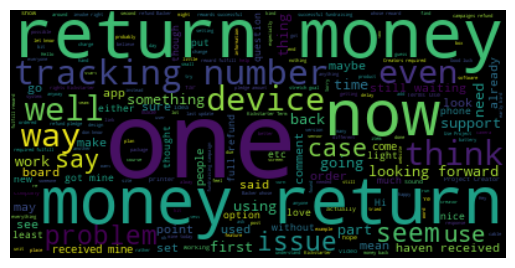

In [ ]:
# Create a WordCloud object
#wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud = WordCloud()
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.rcdefaults()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

Nube de palabras de data pre-procesada

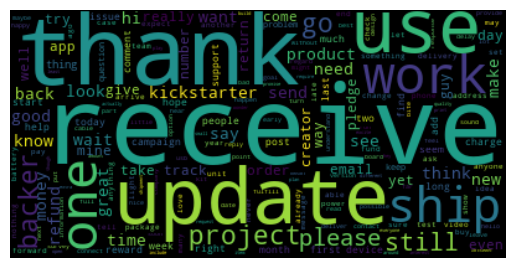

In [ ]:
# Solo para obtener la nube de palabras de la data original
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(X)
# Create a WordCloud object
#wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud = WordCloud(collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
#wordcloud.to_image()
plt.rcdefaults()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# Separando en train y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, stratify = Y, random_state=0)

In [ ]:
print(X_train[:5])
print(y_train[:5])

['kuwagatabaizan', 'let', 'kuwagatabaizan', 'creator couple question please clarify pledge get solar seeker look like one solar seeker comprise location mount solar panel inverter retail cost complete system position sun predictable name location solar seeker smart enough look right direction sunrise stop look sunset hi great campaign wish best luck campaign project cheer creator netherlands creator look good plan go international succesfull', 'kuwagatabaizan']
[0 0 0 0 0]


In [ ]:
embedding_dim = 100
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer(oov_token=oov_tok)
  tokenizer.fit_on_texts(lines)
  return tokenizer

tokenizer = create_tokenizer(X_train)

In [ ]:
# calculate the maximum document length (without stop words)
def max_length(lines):
  return max([len(s.split()) for s in lines])

# calculate max document length
length_long_sentence = max_length(X_train)
print('Max document length: %d' % length_long_sentence)

Max document length: 30072


In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)

# Diccionario de palabras
word_index = tokenizer.word_index

Vocabulary size: 74096


In [ ]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
  # integer encode
  encoded = tokenizer.texts_to_sequences(lines)
  # pad encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

# encode data
#training_sentences = encode_text(tokenizer, X_train, length_long_sentence)
#testing_sentences = encode_text(tokenizer, X_test , length_long_sentence)
training_sentences = encode_text(tokenizer, X_train, 5000)
testing_sentences = encode_text(tokenizer, X_test , 5000)

In [ ]:
training_sentences[:5]

array([[ 53,   0,   0, ...,   0,   0,   0],
       [103,   0,   0, ...,   0,   0,   0],
       [ 53,   0,   0, ...,   0,   0,   0],
       [ 44, 306,  89, ...,   0,   0,   0],
       [ 53,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [ ]:
print(training_sentences.shape)
print(testing_sentences.shape)

(21800, 5000)
(5451, 5000)


In [ ]:
np.save('comments_X_train.npy', training_sentences)
np.save('comments_X_test.npy', testing_sentences)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('Glove/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
word_index.items()

dict_items([('<OOV>', 1), ('get', 2), ('receive', 3), ('thank', 4), ('would', 5), ('update', 6), ('use', 7), ('work', 8), ('one', 9), ('ship', 10), ('like', 11), ('project', 12), ('backer', 13), ('go', 14), ('still', 15), ('please', 16), ('product', 17), ('time', 18), ('make', 19), ('good', 20), ('look', 21), ('back', 22), ('money', 23), ('see', 24), ('know', 25), ('also', 26), ('hi', 27), ('kickstarter', 28), ('think', 29), ('wait', 30), ('refund', 31), ('u', 32), ('send', 33), ('say', 34), ('want', 35), ('need', 36), ('great', 37), ('really', 38), ('pledge', 39), ('could', 40), ('try', 41), ('well', 42), ('email', 43), ('creator', 44), ('return', 45), ('mine', 46), ('even', 47), ('track', 48), ('app', 49), ('guy', 50), ('take', 51), ('way', 52), ('kuwagatabaizan', 53), ('yet', 54), ('order', 55), ('come', 56), ('day', 57), ('give', 58), ('new', 59), ('number', 60), ('thing', 61), ('campaign', 62), ('support', 63), ('seem', 64), ('much', 65), ('charge', 66), ('today', 67), ('week', 68

In [ ]:
print(embedding_matrix.shape)
embedding_matrix

(74096, 100)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14432999,  0.43950999,  0.58323997, ...,  0.50133997,
         0.49535999,  0.49919999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21888   ,  0.35876   , -0.37537   , ..., -0.37221   ,
         0.57165998, -0.075784  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(training_sentences[3]))

creator couple question please clarify pledge get solar seeker look like one solar seeker comprise location mount solar panel inverter retail cost complete system position sun predictable name location solar seeker smart enough look right direction sunrise stop look sunset hi great campaign wish best luck campaign project cheer creator netherlands creator look good plan go international succesfull ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?

# Experimentación con modelos

In [ ]:
# Fuente de ideas:
# https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

import tensorflow as tf
print(tf.__version__)

2.4.0


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_sample_weight('balanced', np.unique(Y), Y)
# Para que funcione correctamente los pesos de las clases balanceadas, se almacenan como diccionarios
class_weights = {i : class_weights[i] for i in range(2)}
print(class_weights)

{0: 0.6987077585764833, 1: 1.7581290322580645}


In [ ]:
# Fuentes:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://maelfabien.github.io/deeplearning/regu/#

# Para detener el entrenamiento cuando la pérdida en data de prueba empieza a subir. Límite de 2 incrementos.
# Para pérdida se usa mínimo. Para precisión se usa máximo
early_stopper = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

# Para reducir tasa de aprendizaje cuando es muy grande
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.01, patience=5, verbose=1, min_delta=1e-4, mode='max')

# Red Neuronal Recurrente

In [ ]:
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
# Se tiene que dar acceso a Drive para almacenar el mejor modelo del checkpoint
# Fuente:
# https://medium.com/@mukesh.kumar43585/model-checkpoint-google-colab-and-drive-as-persistent-storage-for-long-training-runs-e35ffa0c33d9

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras.callbacks import *
checkpoint_path_RNN ="/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_RNN_comments_model_epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint_RNN = ModelCheckpoint(filepath=checkpoint_path_RNN, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.28.190.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.28.190.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with strategy.scope():
  ##modelo LSTM final simple
  model_rnn = tf.keras.Sequential([
      #tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=length_long_sentence, weights=[embedding_matrix],trainable = False),
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=5000, weights=[embedding_matrix],trainable = False,name="Embedding_comments"),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

opt = tf.keras.optimizers.Adam(learning_rate= 1e-3, decay=1e-6)
model_rnn.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model_rnn.summary()
# Agregar batchnormalization

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_comments (Embeddin (None, 5000, 100)         7409600   
_________________________________________________________________
dropout (Dropout)            (None, 5000, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 7,644,353
Trainable params: 234,753
Non-trainable params: 7,409,600
_________________________________________________________________


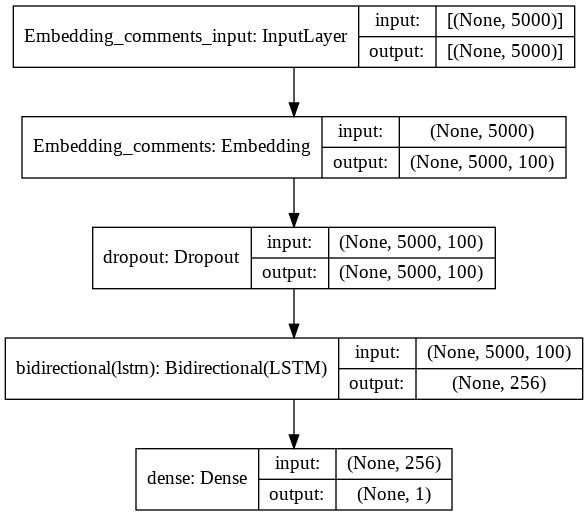

In [ ]:
plot_model(model_rnn, to_file='model_rnn_description.png', show_shapes=True, show_layer_names=True)

In [ ]:
start = datetime.now()

num_epochs = 50
batch_size = 64
hist_rnn = model_rnn.fit(training_sentences,
                 y_train,
                 epochs=num_epochs,
                 batch_size=batch_size,
                 verbose=1,
                 validation_data=(testing_sentences, y_test),
                 class_weight=class_weights,
                 
                 callbacks=[early_stopper, reduce_lr_acc,checkpoint_RNN ],
                 shuffle=False)

stop=datetime.now()
execution_time_rnn = stop-start

Epoch 1/50
341/341 [==============================] - 88s 241ms/step - loss: 0.5633 - accuracy: 0.7984 - val_loss: 0.5330 - val_accuracy: 0.8303

Epoch 00001: val_loss improved from inf to 0.53305, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_RNN_comments_model2_epochs:001-val_accuracy:0.830.hdf5
Epoch 2/50
341/341 [==============================] - 77s 227ms/step - loss: 0.5349 - accuracy: 0.8227 - val_loss: 0.5258 - val_accuracy: 0.8006

Epoch 00002: val_loss improved from 0.53305 to 0.52584, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_RNN_comments_model2_epochs:002-val_accuracy:0.801.hdf5
Epoch 3/50
341/341 [==============================] - 77s 226ms/step - loss: 0.5252 - accuracy: 0.8238 - val_loss: 0.5972 - val_accuracy: 0.8085

Epoch 00003: val_loss did not improve from 0.52584
Epoch 4/50
341/341 [==============================] - 77s 226ms/step - loss: 0.53

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_RNN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_RNN_comments_model_epochs:033-val_accuracy:0.851.hdf5'
model_rnn.load_weights(checkpoint_best_RNN_path)

In [ ]:
score = model_rnn.evaluate(testing_sentences, y_test,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 14s 62ms/step - loss: 0.4548 - accuracy: 0.8467
Test loss:  0.44715529680252075
Test accuracy:  0.8510364890098572


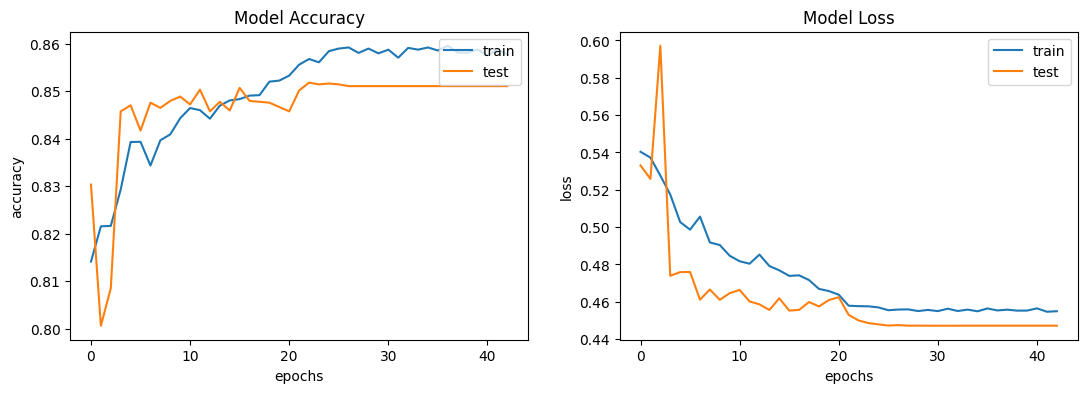

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_rnn.history['accuracy'])
subfig.plot(hist_rnn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_rnn.history['loss'])
subfig.plot(hist_rnn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

171/171 [==============================] - 11s 59ms/step


(2.5, -0.5)

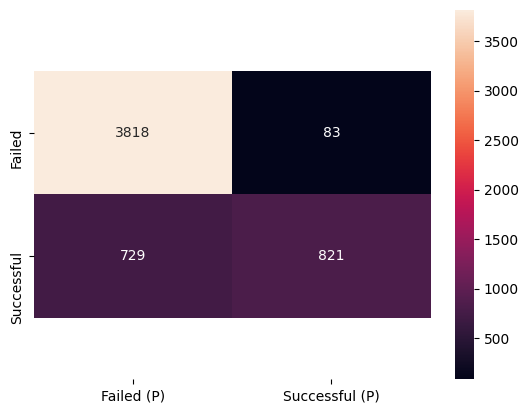

In [ ]:
labels_pred = model_rnn.predict(testing_sentences,verbose=1).ravel()
labels_pred = np.round(labels_pred)

conf_cnn = metrics.confusion_matrix(y_test, labels_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_cnn = sns.heatmap(conf_cnn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_cnn.get_ylim()
ax_cnn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(y_test, labels_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.84      0.98      0.90      3901
  Successful       0.91      0.53      0.67      1550

    accuracy                           0.85      5451
   macro avg       0.87      0.75      0.79      5451
weighted avg       0.86      0.85      0.84      5451



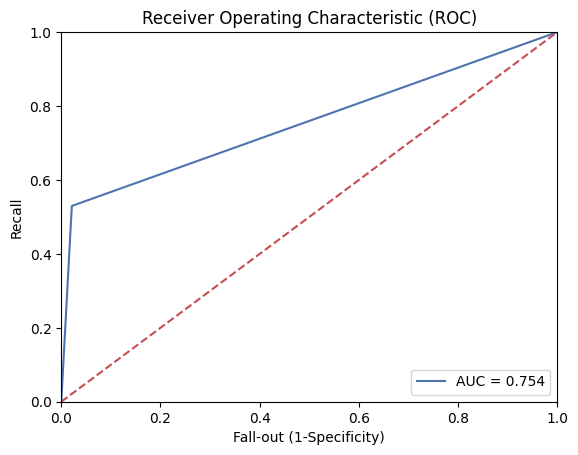

AUC score: 0.7542004118050789


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, labels_pred)
roc_auc_cnn = roc_auc_score(y_test,labels_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_cnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_cnn)

In [ ]:
function ClickConnect(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

In [ ]:
function ClickConnect(){

console.log("Working"); 
document.querySelector("#comments > span").click() 
}
setInterval(ClickConnect,5000)

In [ ]:
# save the model to disk
best_rnn_model_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Mejores/best_RNN_comments_model.h5'
model_rnn.save(best_rnn_model_path)